# EXPLORING ARTIST GENDER BIAS IN MUSIC PREFERENCE AND COLLABORATIVE FILTERING-BASED RECOMMENDATION

Author: Dougal Shakespeare, Lorenzo Porcaro, Emilia Gómez, Carlos Castillo

>Analysis of gender distribution achieved by merging the LastFM360k dataset consisting of Last FM listening histories with artist gender meta-data found in a local config of the MusicBrainz db. The metric of bias-disparity is utalised to assess relative increases in biases towards item categories (in this case gender) subsequent to the production of music recommendations through CF methodologies. 

## 0. Downloading LFM-360k Datasets

Unpack ```lfm360k-data.zip/``` into this current working directory to have access to all file paths used for this experiment and all subsequent lfm-1b notebooks. 


## 1. Import Dataset to DataFrames

We must first remove all artists whose name is a web link as this data is deemed to be dirty. This can be achieved using a simple regex expression (see below):


In [1]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import requests
import re
import os
import h5py
from scipy import sparse
import csv
import random

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

In [3]:
# user-artist le after 75% filtering
lastfm360k_le75_path = 'baseline-data/LastFM360k-Le75.txt'

# files created by data wrangling with MusicBrainz 
dirty_artist_gender_file = 'baseline-data/LastFM360k-MB-artists.txt'

# new files to create...
lastfm360k_le75_filtered_mf_path = 'baseline-data/LastFM360k-le75_mf.csv'
lastfm360k_le75_artists_path = 'baseline-data/artists-LastFM360k-le75.csv'
lastfm360k_le75_users_path = 'baseline-data/users-LastFM360k-le75.csv'

user_file = 'baseline-data/lastfm360k_users.txt'

In [6]:
# Load the artist data into a Pandas dataframe
cols = ['id', 'artist', 'gender_dist', 'mb-id']
artist_gender = pd.read_csv(dirty_artist_gender_file, sep='\t', names=cols)

# initialise new collumn in dataframe to represent classified gender 
artist_gender['identified_gender'] = np.zeros(len(artist_gender))

# print sample of dataframe
artist_gender.head()

,id,artist,gender_dist,mb-id,identified_gender
0,164618,genlevel,1/0/0/0/0,NaN,0.0
1,77828,thelma blankenship,1/0/0/0/0,164221ae-1022-4c93-8227-2b5a8329ae1c,0.0
2,14379,the damning well,0/4/0/0/0,2a3dc878-34f8-48a6-8591-caa8f7b1f70f,0.0
3,53216,andy dick,0/1/0/0/0,2a18326b-450d-4fe0-907c-6d93521e88c1,0.0
4,105916,mr. burns,1/0/0/0/0,c8532d82-7deb-4cfc-be76-bb777688790b,0.0


## 2. Gender Classification

The next step is to classify a gender based on the artists gender_dist. To achieve this we will first consider classifiying gender by which ever gender in the dist has a majority.

In [7]:
# Parse the field gender_dist to be an array for ease of access as it is currently stored as a string in df
def parse_gender(g_dist):
    g_count = g_dist.split("/")   
    return list(map(int, g_count))

gender_dist_list = artist_gender['gender_dist'].map(parse_gender)
artist_gender = artist_gender.assign(gender_dist = gender_dist_list)

In [8]:
def count_ambig_b(g):
    ambig_bc = 0 # ambig band count
    index_drops = []
    for g, index in zip(gender_dist_list, np.arange(len(gender_dist_list))):
        
        max_indexes = [i for i, x in enumerate(g) if x == max(g)]
        if len(max_indexes) > 1:
            index_drops.append(index)
    return index_drops

index_remove = count_ambig_b(gender_dist_list)
print(len(index_remove))

4125


In [9]:
# drop the rows which consist of ambiguous artists (bands with tied gender)
artist_gender = artist_gender.drop(index_remove)

In [10]:
# finds index of the maximum values, if multiple, make random selection
def classify_gender_majority(g):
    max_indexes = [i for i, x in enumerate(g) if x == max(g)]
    return random.choice(max_indexes)

# classify gender
majority_gender = gender_dist_list.map(classify_gender_majority)
# reasign the data frame
artist_gender = artist_gender.assign(identified_gender = majority_gender)

In [11]:
## Print stats of artist gender distribution in LFM-1b-MB dataset
def compute_artist_gender_dist(df_a):
    artist_u = df_a[df_a.identified_gender == 0]
    artist_m = df_a[df_a.identified_gender == 1]
    artist_f = df_a[df_a.identified_gender == 2]
    artist_o = df_a[df_a.identified_gender == 3]
    artist_na = df_a[df_a.identified_gender == 4] 
    return artist_u, artist_m, artist_f, artist_o, artist_na

In [12]:
# Print our newly updated artist_gender dataframe with an array for gender_dist and identified_gender field
artist_gender.head()

,id,artist,gender_dist,mb-id,identified_gender
0,164618,genlevel,"[1, 0, 0, 0, 0]",NaN,0
1,77828,thelma blankenship,"[1, 0, 0, 0, 0]",164221ae-1022-4c93-8227-2b5a8329ae1c,0
2,14379,the damning well,"[0, 4, 0, 0, 0]",2a3dc878-34f8-48a6-8591-caa8f7b1f70f,1
3,53216,andy dick,"[0, 1, 0, 0, 0]",2a18326b-450d-4fe0-907c-6d93521e88c1,1
4,105916,mr. burns,"[1, 0, 0, 0, 0]",c8532d82-7deb-4cfc-be76-bb777688790b,0


## 3. Gender Analysis with the full LastFM360k data-set

We will first consider analysis with the full data-set before considering the user artist matrix distributions which will be used when generating CF recommendations.

### 3.1. Gender Distribution Plots For Artists

In [13]:
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_gender)
#male_count, na_count, female_count, other_count
male_count = len(artist_m)
female_count = len(artist_f)
undef_count = len(artist_u)
other_count = len(artist_o)
na_count = len(artist_na)
total_count = male_count + female_count + undef_count + other_count + na_count

print ('- Undef Gender Count:', undef_count)
print ('- Male Gender Count:', male_count)
print ('- Female Gender Count:', female_count)
print ('- Other Gender Count:', other_count)
print ('- NA Gender Count:', na_count)
print ('- Total:', total_count)

- Undef Gender Count: 207513
- Male Gender Count: 66308
- Female Gender Count: 14448
- Other Gender Count: 25
- NA Gender Count: 62
- Total: 288356


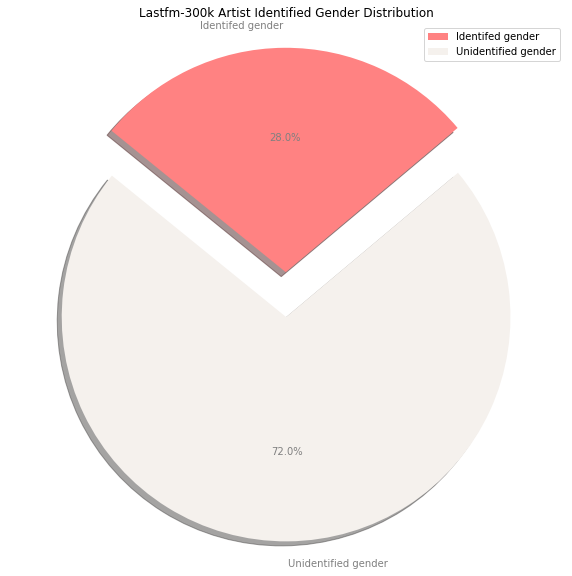

In [14]:
# Pie chart to display succesfully identified artists
labels = 'Identifed gender', 'Unidentified gender'
sizes = [total_count - undef_count, undef_count]

fig1, ax1 = plt.subplots(figsize=(10, 10))
explode = (0.2, 0) 
colors = ['#FF8282','#F5F1ED']

patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=40)

plt.legend(patches, labels, loc="best")

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

plt.rcParams["figure.figsize"] = (2,2)
plt.title('Lastfm-300k Artist Identified Gender Distribution')
plt.show()

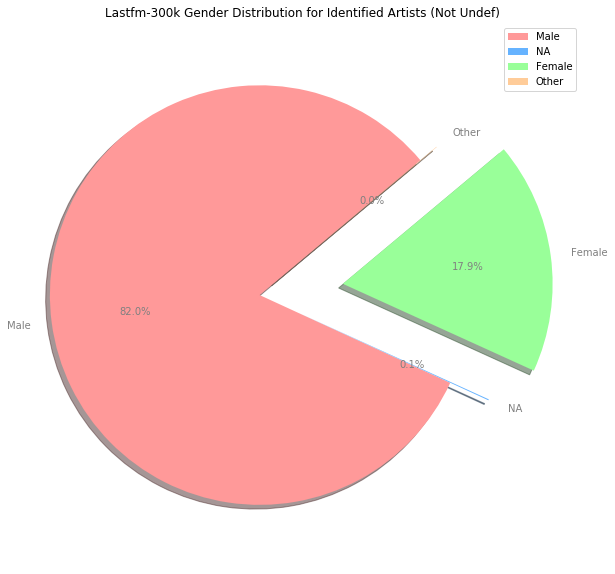

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

labels = 'Male', 'NA', 'Female', 'Other' 
sizes = [male_count, na_count, female_count, other_count]

fig1, ax1 = plt.subplots(figsize=(10, 10))

explode = (0, 0.2, 0.4, 0.1) 
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ffcc91']

patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=40)

plt.legend(patches, labels, loc="best")

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

plt.rcParams["figure.figsize"] = (2,2)
plt.title('Lastfm-300k Gender Distribution for Identified Artists (Not Undef)')

plt.show()

### 3.2. Gender Analysis For Users 


In [16]:
user_df = pd.read_csv(user_file, sep='\t')
# print user data-frame
user_df.head()

,user_id,country,age,gender,playcount,user_sha1
0,351272,Sweden,25.0,f,6175,fa40b43298ba3f8aa52e8e8863faf2e2171e0b5d
1,293958,United States,30.0,m,1590,d1867cbda35e0d48e9a8390d9f5e079c9d99ea96
2,3567,Netherlands,24.0,m,7644,02871cd952d607ba69b64e2e107773012c708113
3,12919,United States,22.0,m,29195,0938eb3d1b449b480c4e2431c457f6ead7063a34
4,320912,United States,NaN,f,7521,e4c6b36e65db3d48474dd538fe74d2dbb5a2e79e


In [17]:
# classify all users with nan as n/a, there is no provided gender information by the user and they therefore fall 
# under this class.
user_df.loc[user_df.gender.isnull(), 'gender'] = 'n'

In [18]:
# User gender distribution analysis
def compute_user_gender_dist(df_u):
    user_m = df_u[df_u.gender == 'm']
    user_f = df_u[df_u.gender == 'f']
    user_u = df_u[df_u.gender == 'n']
    return user_m, user_f, user_u

In [19]:
user_m, user_f, user_u = compute_user_gender_dist(user_df)
user_m_count = len(user_m)
user_f_count = len(user_f)
user_undef_count = len(user_u)
user_total_count = user_m_count + user_f_count + user_undef_count

# Output user gender distribution
print('User Gender Distribution in Matrix:')
print('m count: {}, {}%'.format(user_m_count,user_m_count*100/user_total_count))
print('f count: {}, {}%'.format(user_f_count,user_f_count*100/user_total_count))
print('u count: {}, {}%'.format(user_undef_count,user_undef_count*100/user_total_count))

User Gender Distribution in Matrix:
m count: 241642, 67.24475228678686%
f count: 84930, 23.634537090889864%
u count: 32775, 9.12071062232327%


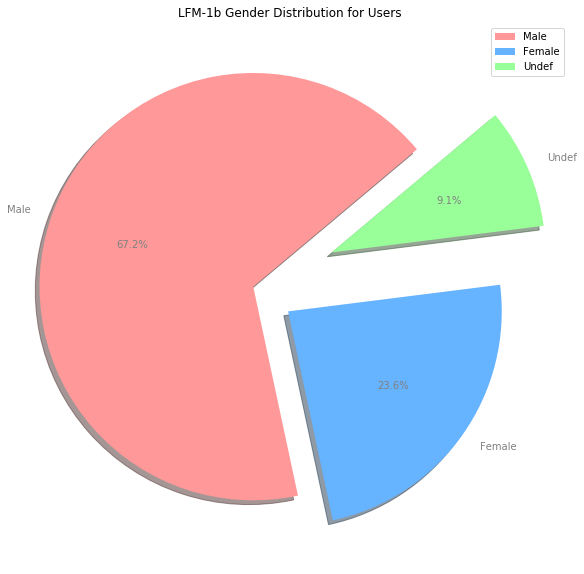

In [20]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Male', 'Female', 'Undef'
sizes = [user_m_count, user_f_count, user_undef_count]

fig1, ax1 = plt.subplots(figsize=(10, 10))

explode = (0, 0.2, 0.4) 
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=40)

plt.legend(patches, labels, loc="best")

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

plt.rcParams["figure.figsize"] = (2,2)
plt.title('LFM-1b Gender Distribution for Users')

plt.show()

## 4. LastFM360k-Le75 Gender Analysis: Users With Le history which consists of >= 75% of artists with known gender

From this matrix we compute ```Lastfm360k_le75.csv```, a csv file containing all user artist listening events for users which have a listening history for which over 75% have known gender. The code for this computation is left out of this notebook due to computational limits.

In [21]:
# read user events (with over 75% gender) into df
df_events = pd.read_csv(lastfm360k_le75_path)
df_events.head()

,userid,artistid,playcount
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706


In [22]:
print('max play count:', df_events.playcount.max())
print('min play count:', df_events.playcount.min())
print('average play count', df_events.playcount.mean())
print('std play count', df_events.playcount.std())

max play count: 419157
min play count: 0
average play count 217.60114299254005
std play count 615.2934133406876


In [23]:
print('total user-artist interactions:', len(df_events))
print('number of artists > 10000:', len(df_events[df_events.playcount > 10000]) /  len(df_events))

total user-artist interactions: 6541600
number of artists > 10000: 0.00031689494924789043


We observe that there a very small number of users which have a high number of listening events > 10000. To compute what may define a recommendation as relevent (i.e. what play count can be considered as a relevent recommendation in evaluations) we first remove outliers in the data by computing the IQR.

In [24]:
df_events_ordered = df_events.sort_values(by=['playcount'], ascending=False)
df_events_ordered 

,userid,artistid,playcount
3601570,197654,926,419157
533911,29430,7060,288375
4769780,261905,355,242328
6198363,340377,4164,219355
1313953,72308,408,186028
...,...,...,...
5746172,315650,748,1
5746173,315650,16013,1
5746174,315650,33226,1
1433091,78875,6019,1


In [25]:
Q1 = df_events.playcount.quantile(0.25)
Q3 = df_events.playcount.quantile(0.75)
IQR = Q3 - Q1
print('Quartile 1 playcounts:', Q1)
print('Quartile 2 playcounts:', Q3)
print('IQR playcounts:', IQR)

Quartile 1 playcounts: 33.0
Quartile 2 playcounts: 228.0
IQR playcounts: 195.0


In [26]:
filter_outliers = df_events[((df_events.playcount < (Q1 - 1.5 * IQR)) == False) & ((df_events.playcount > (Q3 + 1.5 * IQR)) == False)]

In [27]:
print('before filtering df length:', len(df_events))
print('after filtering df length:', len(filter_outliers))

before filtering df length: 6541600
after filtering df length: 5953718


In [28]:
print('max play count:', filter_outliers.playcount.max())
print('min play count:', filter_outliers.playcount.min())
print('average play count', filter_outliers.playcount.mean())
print('std play count', filter_outliers.playcount.std())

max play count: 520
min play count: 0
average play count 121.51305772292204
std play count 119.38874337756037


We now see that the average playcount drops dramatically to aproximately 4. Hence, we consider playcounts >= 4 as the relevent when evaluating filtering methodologies. 

In [29]:
import math
# we will use a logarthmic scale of listening counts to symbolise that listening events >= 70 will be 'relevent' 
math.log(121,1.02)

242.17950849996214

### User gender distribution analysis

In [30]:
user_df

,user_id,country,age,gender,playcount,user_sha1
0,351272,Sweden,25.0,f,6175,fa40b43298ba3f8aa52e8e8863faf2e2171e0b5d
1,293958,United States,30.0,m,1590,d1867cbda35e0d48e9a8390d9f5e079c9d99ea96
2,3567,Netherlands,24.0,m,7644,02871cd952d607ba69b64e2e107773012c708113
3,12919,United States,22.0,m,29195,0938eb3d1b449b480c4e2431c457f6ead7063a34
4,320912,United States,NaN,f,7521,e4c6b36e65db3d48474dd538fe74d2dbb5a2e79e
...,...,...,...,...,...,...
359342,13583,Poland,NaN,m,591,09b6316af9d58716f15cf116d04fc6518d836870
359343,197439,United Kingdom,21.0,m,16626,8cda6be42a1c4bbee3c53d67f892177f8bbf70d2
359344,79477,Germany,29.0,m,6002,38d0e2ceb19f10d9b33b9842ebcf26b7f173bbb5
359345,133691,Spain,29.0,m,1229,5f6aa02a0ace0435fd21ed94f8568309f300cc84


In [31]:
# Gender distribution analysis of users in the le75 matrix.
user_ids_knownlh = df_events['userid'].unique()  #get all unique user ids from LFM-1b-Le75
user_mat_le75_df = user_df[user_df.user_id.isin(user_ids_knownlh)]
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df)

user_m_count = len(user_m)
user_f_count = len(user_f)
user_undef_count = len(user_u)
user_total_count = user_m_count + user_f_count + user_undef_count

print('User Gender Distribution in LFM-1b-Le75 Matrix:')
print('m count: {}, {}%'.format(user_m_count,user_m_count*100/user_total_count))
print('f count: {}, {}%'.format(user_f_count,user_f_count*100/user_total_count))
print('u count: {}, {}%'.format(user_undef_count,user_undef_count*100/user_total_count))

User Gender Distribution in LFM-1b-Le75 Matrix:
m count: 94385, 68.8152992555976%
f count: 30792, 22.450184824689956%
u count: 11980, 8.734515919712447%


### Artist gender distribution analysis

In [32]:
# Gender distribution anlaysis of artists in the le75 matrix
artist_ids_flat = df_events['artistid'].unique()
artist_mat_le75_df = artist_gender[artist_gender.id.isin(artist_ids_flat)]

# merge na class to become other class
artist_mat_le75_df.loc[artist_mat_le75_df['identified_gender'] == 4, 'identified_gender'] = 3

artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df)

artist_m_count = len(artist_m)
artist_f_count = len(artist_f)
artist_undef_count = len(artist_u)
artist_other_count = len(artist_o)
artist_total_count = artist_m_count + artist_f_count + artist_undef_count + artist_other_count 

# Output artist gender distribution
print('Artist Gender Distribution in Matrix')
print('m count: {}, {}%'.format(artist_m_count,artist_m_count*100/artist_total_count))
print('f count: {}, {}%'.format(artist_f_count,artist_f_count*100/artist_total_count))
print('u count: {}, {}%'.format(artist_undef_count,artist_undef_count*100/artist_total_count))
print('o count: {}, {}%'.format(artist_other_count,artist_other_count*100/artist_total_count))

Artist Gender Distribution in Matrix
m count: 50445, 25.534790487664132%
f count: 10455, 5.292223898275914%
u count: 136586, 69.13856464561589%
o count: 68, 0.03442096844407099%


/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:
# filter to just contain user of m and f gender and artists of m and f gender

m_user_ids_sample = user_m['user_id'].values
f_user_ids_sample = user_f['user_id'].values
users_mf = [y for x in [m_user_ids_sample, f_user_ids_sample] for y in x] #male and female users

male_artist_ids = artist_m['id'].unique()
female_artist_ids = artist_f['id'].unique()
artist_sample = [y for x in [male_artist_ids, female_artist_ids] for y in x]

final_le_df = df_events[(df_events.userid.isin(users_mf) & (df_events.artistid.isin(artist_sample)))]

In [34]:
# Analyse our gender dists after updating the manual annotations in the df
artist_mat_le75_df_update = artist_mat_le75_df[artist_mat_le75_df.id.isin(final_le_df.artistid.unique())]
user_mat_le75_df_update = user_mat_le75_df[user_mat_le75_df.user_id.isin(final_le_df.userid.unique())]

# Gender distribution analysis
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df_update)
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df_update)

### Preference Ratio Distributions

In [35]:
final_le_df = pd.read_csv(lastfm360k_le75_filtered_mf_path)

In [36]:
user_ids = final_le_df.userid.unique()

In [37]:
f_pref = []
m_pref = []

for u in user_ids:
    df = final_le_df[final_le_df.userid == u]
    item_len = len(df)
    f_items = df[df.artistid.isin(list(artist_f.id))]
    f_pref_u = len(f_items) / item_len
    m_pref_u = 1 - f_pref_u
    f_pref.append(f_pref_u)
    m_pref.append(m_pref_u)

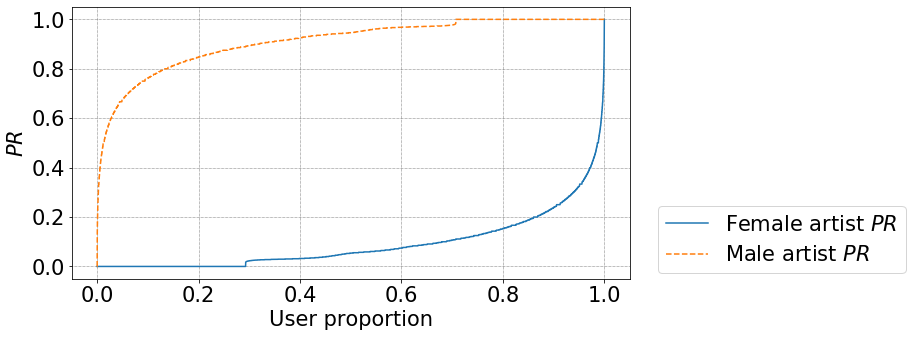

In [38]:
## Plot the distribution of user input preferences in the data

%matplotlib inline
plt.rcParams.update({'font.size': 21})

plt.rcParams["figure.figsize"] = [10, 5]
x = np.arange(1,len(user_ids)+1)
x = [i/len(user_ids) for i in x]
plt.figure()
plt.xlabel('User proportion')
plt.ylabel('$PR$')
plt.plot(x, sorted(f_pref), label='Female artist $PR$')
plt.plot(x, sorted(m_pref), linestyle='dashed', label='Male artist $PR$')
plt.legend(loc=(1.05,0.02))
plt.grid(linestyle=':', linewidth='0.5', color='black')

In [39]:
user_dimension = len(final_le_df.userid.unique())
artist_dimension = len(final_le_df.artistid.unique())
print('Dimentionality of final matrix: {} - {}'.format(user_dimension, artist_dimension) )

Dimentionality of final matrix: 125142 - 60980


### Write both user and artist dfs to csv files

In [40]:
final_le_df.to_csv(lastfm360k_le75_filtered_mf_path, index = False)

In [41]:
# write our updated user and artist matrix to csv files to be used in subsequent experiments
artist_mat_le75_df.to_csv(lastfm360k_le75_artists_path, index = False)
user_mat_le75_df_update.to_csv(lastfm360k_le75_users_path, index = False)

### Analysis of of gender distributions in the longtail

In [42]:
# Compute artists which are in the longtail
artist_unique_users = final_le_df['artistid'].value_counts()
artist_playcounts = final_le_df[['artistid','playcount']].groupby(['artistid']).mean()
combined_df = pd.concat([artist_unique_users , artist_playcounts], axis=1)
    
combined_df.columns = ['user_count', 'avg_playcount']
combined_df['popularity'] = combined_df['user_count']*combined_df['avg_playcount']
combined_df = combined_df.sort_values(by=['popularity'])
artists = combined_df.index.values.tolist()
slice_i = int(len(artists) * 0.8) #consider 80% as the longtail
lt_artists = artists[:slice_i]
th_artists = artists[slice_i:]

In [43]:
th_artists_df = artist_mat_le75_df[artist_mat_le75_df.id.isin(th_artists)]
th_artist_u, th_artist_m, th_artist_f, th_artist_o, th_artist_na = compute_artist_gender_dist(th_artists_df)
#th_artist_f
total_a = len(th_artist_m) + len(th_artist_f)
print('male top head artists {} / {}%'.format(len(th_artist_m),(len(th_artist_m)*100)/total_a))
print('female top head artists {} / {}%'.format(len(th_artist_f),(len(th_artist_f)*100)/total_a))

male top head artists 10113 / 86.98606571477723%
female top head artists 1513 / 13.013934285222776%


In [44]:
longt_artists = artist_mat_le75_df[artist_mat_le75_df.id.isin(lt_artists)]
lt_artist_u, lt_artist_m, lt_artist_f, lt_artist_o, lt_artist_na = compute_artist_gender_dist(longt_artists)
total_a = len(lt_artist_m) + len(lt_artist_f)

print('male long tail artists {} / {}%'.format(len(lt_artist_m),(len(lt_artist_m)*100)/total_a))
print('female long tail artists {} / {}%'.format(len(lt_artist_f),(len(lt_artist_f)*100)/total_a))

male long tail artists 38650 / 81.95330887809843%
female long tail artists 8511 / 18.04669112190157%


### Analaysis of gender distribution of most popular artists

In [45]:
most_popular_artists_df = df_events[['artistid','playcount']].groupby('artistid').sum()

In [46]:
most_popular_artists_df = most_popular_artists_df.sort_values(by=['playcount'], ascending=False)
top100_artist_ids = most_popular_artists_df.index[:1000]

In [47]:
most_popular_artists_df['artistid'] = most_popular_artists_df.index

In [48]:
top100_artists = artist_mat_le75_df[artist_mat_le75_df.id.isin(top100_artist_ids)]

In [49]:
# Gender distribution analysis
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(top100_artists)

artist_m_count = len(artist_m)
artist_f_count = len(artist_f)
artist_undef_count = len(artist_u)
artist_other_count = len(artist_o)
artist_total_count = artist_m_count + artist_f_count + artist_undef_count + artist_other_count 

# Output artist gender distribution
print('Artist Gender Distribution in Matrix')
print('m count: {}, {}%'.format(artist_m_count,artist_m_count*100/artist_total_count))
print('f count: {}, {}%'.format(artist_f_count,artist_f_count*100/artist_total_count))
print('u count: {}, {}%'.format(artist_undef_count,artist_undef_count*100/artist_total_count))
print('o count: {}, {}%'.format(artist_other_count,artist_other_count*100/artist_total_count))

Artist Gender Distribution in Matrix
m count: 672, 70.66246056782335%
f count: 43, 4.52155625657203%
u count: 236, 24.815983175604625%
o count: 0, 0.0%


In [50]:
for id_a in artist_m.id.values:
    pc = most_popular_artists_df[most_popular_artists_df.artistid == id_a].playcount.values[0]
    artist_m.loc[artist_m['id'] == id_a, 'playcount'] = pc

    
artist_m.sort_values(by=['playcount'], ascending=False)[:10]

/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,artist,gender_dist,mb-id,identified_gender,playcount
23457,217,radiohead,"[0, 5, 0, 0, 0]",a74b1b7f-71a5-4011-9441-d0b5e4122711,1,6165826.0
104294,247,the beatles,"[0, 6, 0, 0, 0]",b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,1,5406294.0
283457,312,in flames,"[0, 13, 0, 0, 0]",31745282-b1ea-4d62-939f-226b14d68e7c,1,4924537.0
164829,283,metallica,"[0, 8, 0, 0, 0]",65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,1,4261072.0
288036,277,muse,"[0, 3, 0, 0, 0]",9c9f1380-2516-4fc9-a3e6-f9f61941d090,1,4175174.0
201266,96,death cab for cutie,"[2, 4, 0, 0, 0]",0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,1,3968754.0
58875,193,system of a down,"[0, 5, 0, 0, 0]",cc0b7089-c08d-4c10-b6b0-873582c17fd6,1,3766483.0
81007,62,coldplay,"[0, 4, 0, 0, 0]",cc197bad-dc9c-440d-a5b5-d52ba2e14234,1,3531825.0
214887,352,linkin park,"[2, 7, 0, 0, 0]",f59c5520-5f46-4d2c-b2c4-822eabf53419,1,3416807.0
235599,773,nine inch nails,"[5, 23, 2, 0, 0]",b7ffd2af-418f-4be2-bdd1-22f8b48613da,1,3379988.0


In [51]:
for id_a in artist_f.id.values:
    pc = most_popular_artists_df[most_popular_artists_df.artistid == id_a].playcount.values[0]
    artist_f.loc[artist_f['id'] == id_a, 'playcount'] = pc

artist_f.sort_values(by=['playcount'], ascending=False)[:10]

,id,artist,gender_dist,mb-id,identified_gender,playcount
239409,121,björk,"[0, 0, 1, 0, 0]",87c5dedd-371d-4a53-9f7f-80522fb7f3cb,2,1257140.0
157787,944,avril lavigne,"[0, 0, 1, 0, 0]",0103c1cc-4a09-4a5d-a344-56ad99a77193,2,1133039.0
18752,355,madonna,"[0, 0, 1, 0, 0]",79239441-bfd5-4981-a70c-55c3f15c1287,2,1106060.0
177873,550,britney spears,"[0, 0, 1, 0, 0]",45a663b5-b1cb-4a91-bff6-2bef7bbfdd76,2,935535.0
101810,519,regina spektor,"[0, 0, 1, 0, 0]",fbb375f9-48bb-4635-824e-4120273b3ba7,2,883801.0
167421,971,feist,"[0, 0, 1, 0, 0]",a670e05a-cea8-4b37-bce9-d82daf1a0fa4,2,848077.0
33297,798,cat power,"[0, 0, 1, 0, 0]",05755bf1-380c-487f-983f-d1a02401fa28,2,798827.0
154376,409,amy winehouse,"[0, 0, 1, 0, 0]",dfe9a7c4-8cf2-47f4-9dcb-d233c2b86ec3,2,779929.0
110689,1266,enya,"[0, 0, 1, 0, 0]",4967c0a1-b9f3-465e-8440-4598fd9fc33c,2,752501.0
67319,408,t.a.t.u.,"[0, 0, 2, 0, 0]",7c20f558-d664-42bd-b6f1-81acf9dbb72d,2,646860.0
